In [1]:
import torch
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from typing import List, Tuple
from src.util.cameras import PatchPerspectiveCameras, get_patch_ndc_to_screen_transform, get_screen_to_patch_ndc_transform

In [2]:
def create_test_image(image_size: Tuple[int, int]) -> torch.Tensor:
    """
    Creates a simple test image with a colored square.
    """
    test_image = torch.zeros((image_size[0], image_size[1], 3), dtype=torch.float32)
    # Adding a colored square
    test_image[50:150, 50:150, :] = torch.tensor([1.0, 0.0, 0.0])  # Red square
    return test_image

In [3]:
def create_patches_of_test_image(test_image: torch.Tensor, patch_sizes: List[Tuple[int, int]], patch_centers: List[Tuple[int, int]]) -> List[torch.Tensor]:
    """
    Creates patches of the test image based on the provided patch sizes and centers.
    """
    patches = []
    for patch_size, patch_center in zip(patch_sizes, patch_centers):
        patch = test_image[patch_center[0]-patch_size[0]//2:patch_center[0]+patch_size[0]//2, 
                           patch_center[1]-patch_size[1]//2:patch_center[1]+patch_size[1]//2, :]
        patches.append(patch)
    return patches

In [4]:
def plot_patch_transformations(test_image: torch.Tensor, patches: List[torch.Tensor], patch_sizes: torch.Tensor, patch_centers: torch.Tensor, 
                               image_size: Tuple[int, int], camera_distance: float = 2.0):
    """
    Plots the patches and their transformations.
    """
    fig = plt.figure(figsize=(10, 5))
    
    # Plot the original image
    ax1 = fig.add_subplot(2, 4, 1)
    ax1.imshow(test_image)
    ax1.set_title('Original Image')
    
    for i, patch in enumerate(patches):
        ax = fig.add_subplot(2, 4, i+2)
        ax.imshow(patch)
        ax.add_patch(Rectangle((patch_centers[i][1]-patch_sizes[i][1]//2, patch_centers[i][0]-patch_sizes[i][0]//2), patch_sizes[i][1], patch_sizes[i][0], fill=None, edgecolor="blue", linewidth=2))
        ax.set_title('Patch {}'.format(i+1))
    
    # Initialize cpu
    patch_cameras = PatchPerspectiveCameras(device="cpu")
    
    for i, patch in enumerate(patches):
        # Transform from NDC to screen
        ndc_to_screen_transform = get_patch_ndc_to_screen_transform(patch_cameras, 
                                                                    image_size=image_size, 
                                                                    patch_size=patch_sizes[i], 
                                                                    patch_center=patch_centers[i])
        # Plot transformed patches
        ax = fig.add_subplot(2, 4, i+6)
        transformed_patch_ndc_to_screen = ndc_to_screen_transform.transform_points(torch.cat([patch_centers[i].unsqueeze(0), torch.ones(1, 1)], dim=1)).squeeze()
        ax.imshow(patch)
        ax.add_patch(Rectangle((transformed_patch_ndc_to_screen[1]-patch_sizes[i][1]//2, transformed_patch_ndc_to_screen[0]-patch_sizes[i][0]//2), patch_sizes[i][1], patch_sizes[i][0], fill=None, edgecolor="green", linewidth=2))
        ax.set_title('Transformed Patch {}'.format(i+1))
        
    plt.tight_layout()
    plt.show()
    return transformed_patch_ndc_to_screen

In [5]:
def test_ndc_to_screen_transformation(image_size: Tuple[int, int], patch_sizes: torch.Tensor, patch_centers: torch.Tensor):
    """
    Test the transformation from NDC to screen space.
    """
    # Define test image and patches
    test_image = create_test_image(image_size)
    patches = create_patches_of_test_image(test_image, patch_sizes, patch_centers)
    
    # Plot patches and their transformations
    transformed_patch_ndc_to_screen = plot_patch_transformations(test_image, patches, patch_sizes, patch_centers, image_size)
    return transformed_patch_ndc_to_screen

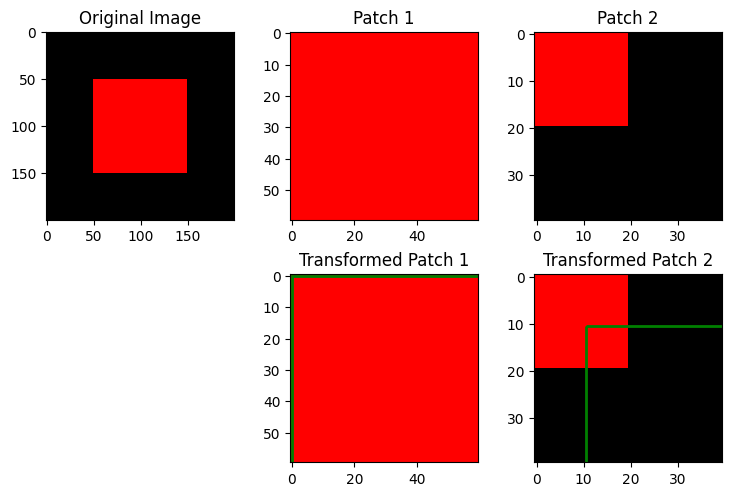

In [6]:
# Define image size and create a test image
image_size = (200, 200)

# Define patch sizes and centers
patch_sizes = torch.tensor([(60, 60), (40, 40)])
patch_centers = torch.tensor([(100, 100), (150, 150)])

# Test the transformation
transformed_patch_ndc_to_screen = test_ndc_to_screen_transformation(image_size, patch_sizes, patch_centers)

In [7]:
transformed_patch_ndc_to_screen

tensor([30.5000, 30.5000,  1.0000])

In [8]:
print("Original patch center in screen space: ", patch_centers)
print("Transformed patch center in screen space: ", transformed_patch_ndc_to_screen)

Original patch center in screen space:  tensor([[100, 100],
        [150, 150]])
Transformed patch center in screen space:  tensor([30.5000, 30.5000,  1.0000])
